This file is part of a program that is used to develop an objective way to
segment the fetus from ultrasound images, and to analyse the effectiveness of 
using the resulting mask to produce an unobstructed visualisation of the fetus.
The research is organised in three phases: (1) noise reduction filters, 
(2a) heuristic segmentation models, (2b) deep learning segmentation
approach (U-net), and (3) the volume visualisation. The program is developed
for the master Computational Science at the UvA from February to November 2020.

This file contains code for the heuristic segmentation models. <br>
You can run this file to plot the results of the statistics and the corresponding images.
 
Made by Romy Meester


In [1]:
"""
Phase 2a: The heuristic segmentation models:
- semi-automatic watershed segmentation
- fully automatic watershed segmentation
"""

import os
import pickle
import numpy as np
import pandas as pd
import time
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
from jupyterthemes import jtplot

In [2]:
jtplot.style(context='paper', fscale=1.6, ticks=True, grid=False)

In [3]:
# Constants
DATA_PATH = '../datasets/'
RESULTS_PATH = 'results_heuristic_models'
RESULTS_IMG_PATH = os.path.join(RESULTS_PATH, 'results_heuristics_img')
RESULTS_STATS_PATH = os.path.join(RESULTS_PATH, 'results_heuristics_stats')
RESULTS_VIS_PATH = os.path.join(RESULTS_PATH, 'results_heuristics_visualisations') 
RESULTS_PLOTS_PATH = os.path.join(RESULTS_VIS_PATH, 'results_plot_stats_img')

In [4]:
def create_dir(PATH):
    """ Create a directory. """
    try:
        os.mkdir(PATH)
        print('Directory', PATH, 'created' )
    except FileExistsError:
        print('Directory', PATH, 'already exists' )

# create results folder for visualisations (plots)
create_dir(RESULTS_VIS_PATH)    

# create results folder for images (slices)
create_dir(RESULTS_PLOTS_PATH)

Directory results_heuristic_models\results_heuristics_visualisations already exists
Directory results_heuristic_models\results_heuristics_visualisations\results_plot_stats_img already exists


In [5]:
def load_data_pickle(PATH, filename):
    """ Load data from file using pickle. """
    with open(PATH + '/' + filename + ".pkl","rb") as f:
        new_data = pickle.load(f)
    return new_data

In [6]:
results = load_data_pickle(PATH = RESULTS_STATS_PATH, filename='results_pickle')
results.keys()

dict_keys(['DSC', 'IoU', 'HD'])

# The results in a table 

In [7]:
# the results in a table with mean and std
for metric, models in results.items():
    print(metric)
    for model, values in models.items():
        print(model, len(values), round(np.mean(values),3), round(np.std(values),3))

DSC
ws_fullyauto_org 7 0.895 0.019
ws_fullyauto_smoothed 7 0.73 0.272
ws_semiauto_org 7 0.892 0.051
ws_semiauto_smoothed 7 0.705 0.309
IoU
ws_fullyauto_org 7 0.81 0.031
ws_fullyauto_smoothed 7 0.637 0.29
ws_semiauto_org 7 0.808 0.078
ws_semiauto_smoothed 7 0.621 0.321
HD
ws_fullyauto_org 7 47.14 16.94
ws_fullyauto_smoothed 7 39.113 12.526
ws_semiauto_org 7 32.586 14.132
ws_semiauto_smoothed 7 44.011 21.978


# The results in a barplot

In [8]:
def get_means(data):
    """ Get the mean values of the models per metric. """

    # get the lists of values per dataset
    results = []
    for i in range(len(list(data.values())[0])):
        result = []
        for filters, filtervalues in data.items():
            result.append(filtervalues[i])
        results.append(result)

    # calculate the mean and standard deviation per dataset
    results_mean = []
    results_std = []
    for i in results:
        results_mean.append(np.mean(i))
        results_std.append(np.std(i))
    
    return results_mean, results_std

In [9]:
# create the dataframes
num_datasets = list(range(1, len(results['DSC']['ws_fullyauto_org'])+1))
dsc_mean, dsc_std = get_means(results['DSC'])
iou_mean, iou_std = get_means(results['IoU'])
hd_mean, hd_std = get_means(results['HD'])

df_mean = pd.DataFrame({'DSC': dsc_mean,
                       'IoU': iou_mean,
                       'HD': hd_mean}, 
                       index=num_datasets)

In [10]:
df_mean

,DSC,IoU,HD
1,0.916487,0.846120,25.338625
2,0.829536,0.712015,30.176802
3,0.601793,0.517361,30.689738
4,0.574832,0.476532,63.280174
5,0.905116,0.826898,48.913730
6,0.914413,0.842624,37.477470
7,0.896190,0.812159,49.111244


In [11]:
# # show the results
print('highest DSC:', df_mean['DSC'].max(), '   best dataset: ', str('dataset' + str(df_mean.DSC.idxmax())))
print('highest IoU:', df_mean['IoU'].max(), '   best dataset: ', str('dataset' + str(df_mean.IoU.idxmax())))
print('lowest HD:', df_mean['HD'].min(), '     best dataset: ', str('dataset' + str(df_mean.HD.idxmin())))
print()
print('lowest DSC:', df_mean['DSC'].min(), '    worst dataset: ', str('dataset' + str(df_mean.DSC.idxmin())))
print('lowest IoU:', df_mean['IoU'].min(), '    worst dataset: ', str('dataset' + str(df_mean.IoU.idxmin())))
print('highest HD:', df_mean['HD'].max(), '    worst dataset: ', str('dataset' + str(df_mean.HD.idxmax())))

highest DSC: 0.9164868506935343    best dataset:  dataset1
highest IoU: 0.8461196756625371    best dataset:  dataset1
lowest HD: 25.338624553860075      best dataset:  dataset1

lowest DSC: 0.5748323771887692     worst dataset:  dataset4
lowest IoU: 0.4765319841819268     worst dataset:  dataset4
highest HD: 63.280173809333974     worst dataset:  dataset4


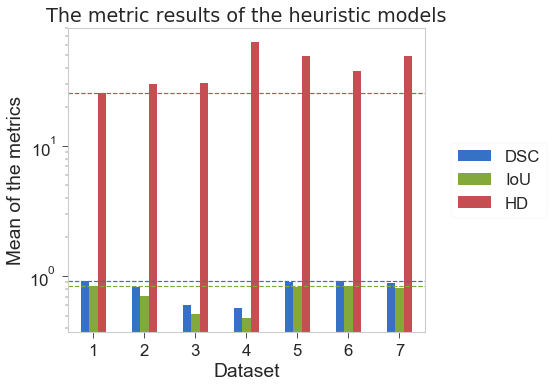

In [12]:
# Build the plot
ax = df_mean.plot.bar(rot=0)
plt.axhline(y=df_mean['DSC'].max(), color='b', linestyle='--')
plt.axhline(y=df_mean['IoU'].max(), color='g', linestyle='--')
plt.axhline(y=df_mean['HD'].min(), color='r', linestyle='--')
plt.yscale('log')

ax.set_title("The metric results of the heuristic models", fontname="DejaVu Sans")
ax.set_xlabel('Dataset')
ax.set_ylabel('Mean of the metrics')

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.65))
# plt.tight_layout()
plt.savefig(RESULTS_VIS_PATH + '/' + 'heuristics_stackedbarchart.png')
plt.show()


### boxplot

In [13]:
num_datasets = len(results['DSC']['ws_fullyauto_org'])
num_models = len(results['DSC'])
num_metrics = len(results)

In [14]:
# modelnames and datasetnumbers 
modelnames = []
datasetnumbers = []
modelname = list(results['DSC'])

for model in range(num_models):
    for data in range(num_datasets):
        datasetnumbers.append(data+1)
        if modelname[model] == 'ws_semiauto_org':
            modelnames.append('A')
        elif modelname[model] == 'ws_semiauto_smoothed':
            modelnames.append('B')
        elif modelname[model] == 'ws_fullyauto_org':
            modelnames.append('C')
        elif modelname[model] == 'ws_fullyauto_smoothed':
            modelnames.append('D')

In [15]:
def fill_metriclist(metric_name, data):
    """" Fill the metriclist with the values. """
    for model, values in data.items():
        for value in values: 
            metric_name.append(value)

# metric values 
dsc = []
iou = []
hd = []

for metrics, values in results.items():
    if metrics == 'DSC': 
        fill_metriclist(dsc, values)
    if metrics == 'IoU': 
        fill_metriclist(iou, values)
    if metrics == 'HD': 
        fill_metriclist(hd, values)

In [16]:
# the dataset
data = []
data.append(modelnames)
data.append(datasetnumbers)
data.append(dsc)
data.append(iou)
data.append(hd)

In [17]:
# make pandas dataframe
rows = zip(data[0], data[1], data[2], data[3], data[4])
headers = ['Model', 'Dataset', 'DSC', 'IoU', 'HD']
df = pd.DataFrame(rows, columns=headers)

In [18]:
df.head()

,Model,Dataset,DSC,IoU,HD
0,C,1,0.900487,0.818987,39.408121
1,C,2,0.876336,0.779892,38.065733
2,C,3,0.936587,0.880736,15.297059
3,C,4,0.888139,0.798786,55.308227
4,C,5,0.889401,0.800830,58.017239


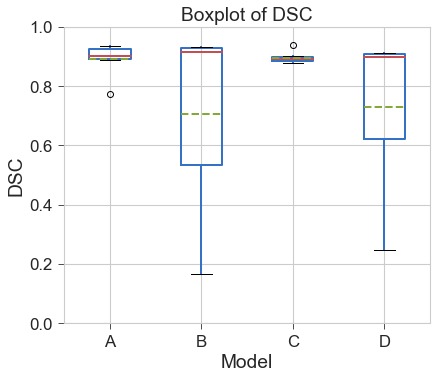

In [19]:
def show_boxplot(metric, groupby, y_lim=None):
    """ Show the boxplot of the metric. """
    
    boxplot = df.boxplot(column=[metric], by=[groupby], 
                         boxprops = dict(linewidth=2), flierprops = dict(linewidth=2),
                         whiskerprops = dict(linewidth=2), 
                         medianprops = dict(linewidth=2), 
                         showmeans=True, meanline=True, 
                         meanprops= dict(linewidth=2, color='g'))
                         
    try:
        plt.ylim(y_lim[0], y_lim[1])
    except:
        pass
    
    plt.title( 'Boxplot of {metric}'.format(metric=metric))
    plt.suptitle('')
    plt.xlabel(groupby)
    plt.ylabel(metric)
    plt.tight_layout()
    plt.savefig(RESULTS_VIS_PATH + '/' + 'boxplot_' + metric + '.png')
    plt.show()
    
show_boxplot(metric = 'DSC', groupby='Model', y_lim=[0,1])


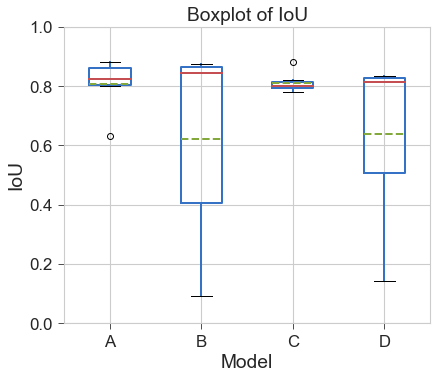

In [20]:
show_boxplot(metric = 'IoU', groupby='Model', y_lim=[0,1])

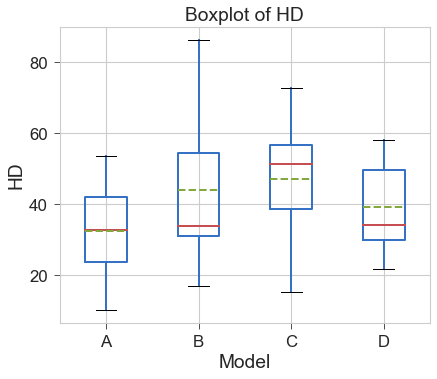

In [21]:
show_boxplot(metric = 'HD', groupby='Model')

# Show and save the images (of the best performing dataset)

In [22]:
def load_scans(pathDicom):
    """ Load the dicom files into sitk with the image series reader.
    Input: path of the directory with the dicom files.
    Output: the 3D image.
    """
    reader = sitk.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
    reader.SetFileNames(filenamesDICOM)
    img = reader.Execute()
    return img

In [23]:
# create a dictionary with the original images 
def get_data_dcm(rootdir, scans = 'org'):
    """ Generate the dataset of dcm files in a dictionary. """
    
    datasets = {}
    
    # the folders
    datasetnames = [f for f in os.listdir(rootdir) if os.path.isdir(os.path.join(rootdir, f))]
    print('Loading: ' + str(len(datasetnames)) + ' datasets')
    
    # which scans
    if scans == 'org':
        scan = '/crop_org'
    elif scans == 'gt':
        scan = '/crop_gt'
    
    # load scans to numpy
    for dataset in tqdm(datasetnames):
        time.sleep(0.1)
        
        images = load_scans(rootdir + dataset + scan) 
        images = sitk.GetArrayFromImage(images)
        
        # Save images in datasets dictionary
        datasets.update({dataset: images})

    print("datasets created")
    return datasets
    

In [24]:
# the original images in numpy arrays
org_images = get_data_dcm(DATA_PATH, scans ='org')

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Loading: 7 datasets


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.16s/it]

datasets created


In [25]:
# the ground truth images in numpy arrays
gt_images = get_data_dcm(DATA_PATH, scans ='gt')

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Loading: 7 datasets


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.59it/s]

datasets created


In [26]:
# load all the heuristic model images
def load_data_pickle(PATH, filename):
    """ Load data from file using pickle. """
    with open(PATH + '/' + filename,"rb") as f:
        new_data = pickle.load(f)
    return new_data

filenames = [f for f in os.listdir(RESULTS_IMG_PATH) if os.path.isfile(os.path.join(RESULTS_IMG_PATH, f))]
heuristic_images = {}

for file in filenames:
    filename = file[:-4]
    image = load_data_pickle(RESULTS_IMG_PATH, file)
    heuristic_images.update({filename : image})
    

In [27]:
# generate colored images 
def create_colors(frame_gt, frame_prediction):
    """ Create colored predicted image by comparing the prediction
    to the ground truth. True positives are white, false positives green, 
    and false negatives red. """
    
    frame_result = np.zeros((frame_prediction.shape[0],frame_prediction.shape[1], frame_prediction.shape[2] ,3), dtype=np.uint8)
    frame_result[frame_prediction == 1] = [255, 255, 255] # white: true positives

    frame_result[(frame_prediction == 1) & (frame_gt == 0)] = [0, 255, 0] # green: false positives
    frame_result[(frame_prediction == 0) & (frame_gt == 1)] = [255, 0, 0] # red: false negatives

    return frame_result


def generate_colorimage(predicted_datasets, gt_datasets):
    """ Generate the colored predicted image. """
    
    datasets = {}
 
    # compare the predicted images to the ground truth 
    for predicted_key, predicted_image in predicted_datasets.items():
        dataset_key = predicted_key.split('_', 1)[0]
        image = create_colors(gt_datasets[dataset_key], predicted_image)
        
        # Save images in datasets dictionary
        datasets.update({predicted_key: image})
        
    print("datasets created") 
    return datasets


In [28]:
# the images of the inverted masks
colored_heuristicimages = generate_colorimage(heuristic_images, gt_images)

datasets created


dataset1 76/151 (115, 141)


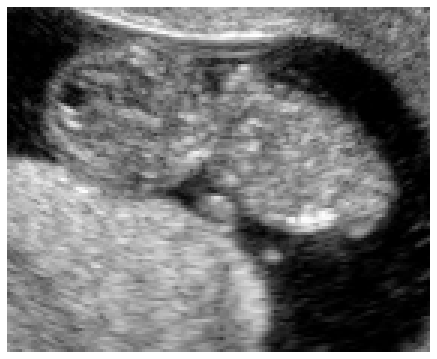

dataset2 58/115 (87, 148)


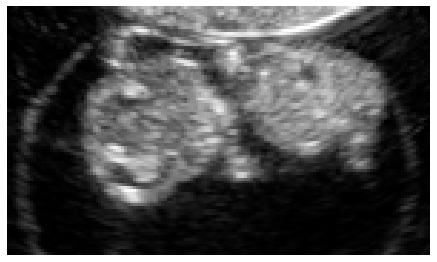

dataset3 52/104 (148, 155)


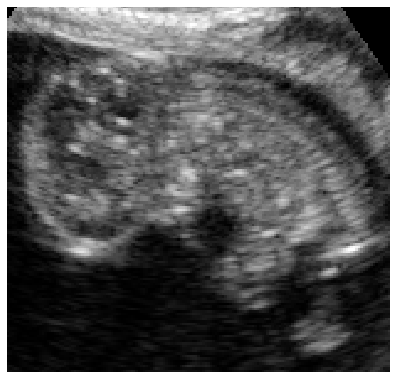

dataset4 72/143 (111, 131)


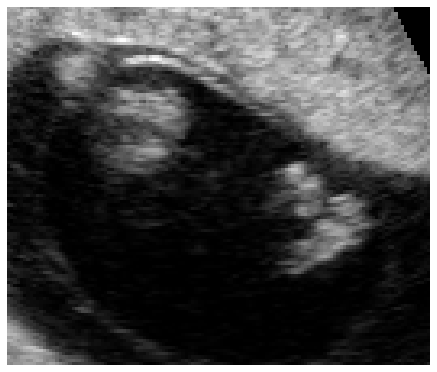

dataset5 104/207 (144, 180)


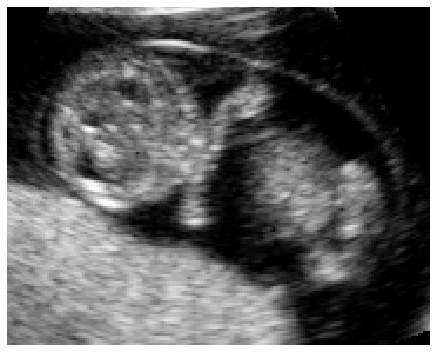

dataset6 90/180 (112, 140)


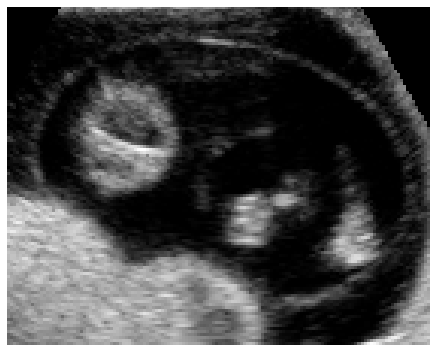

dataset7 92/184 (161, 181)


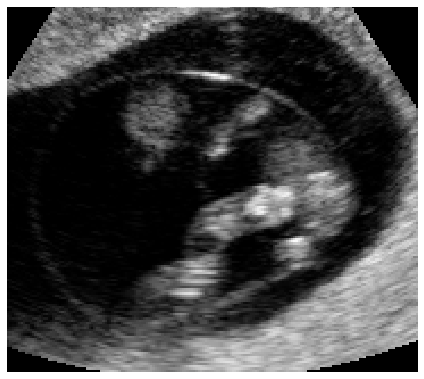

dataset1 76/151 (115, 141)


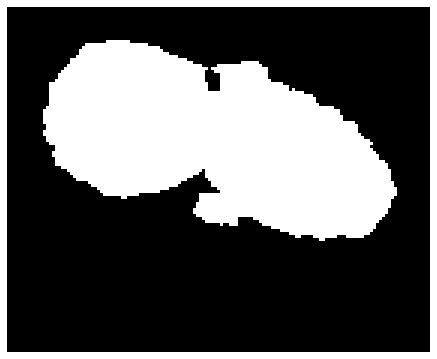

dataset2 58/115 (87, 148)


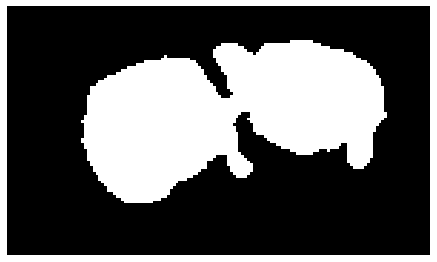

dataset3 52/104 (148, 155)


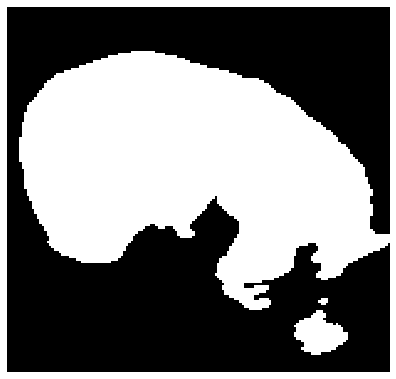

dataset4 72/143 (111, 131)


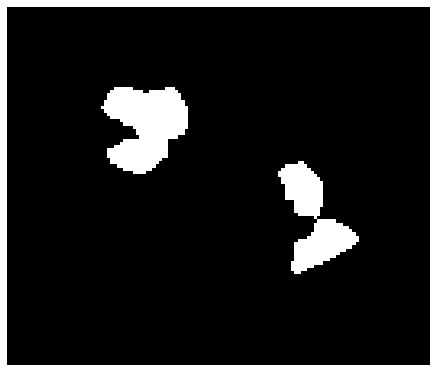

dataset5 104/207 (144, 180)


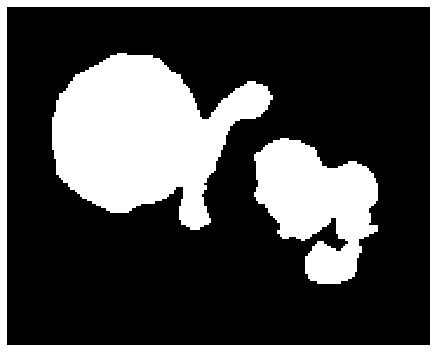

dataset6 90/180 (112, 140)


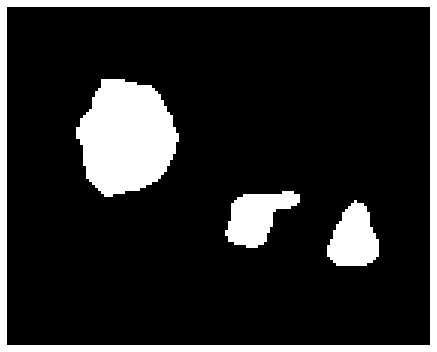

dataset7 92/184 (161, 181)


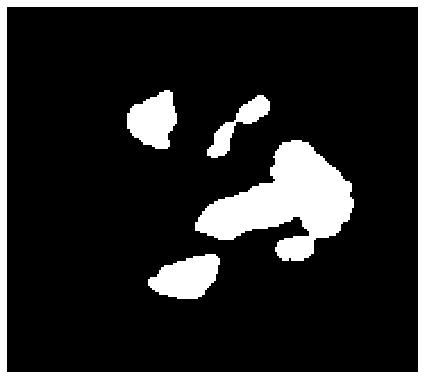

dataset1_ws_fullyauto_org 76/151 (115, 141, 3)


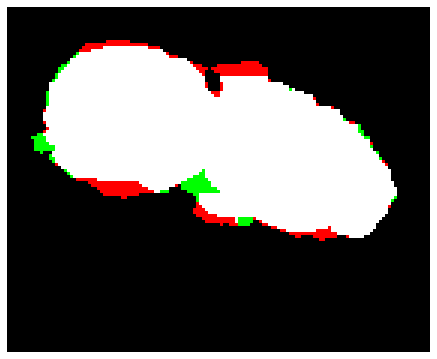

dataset1_ws_fullyauto_smoothed 76/151 (115, 141, 3)


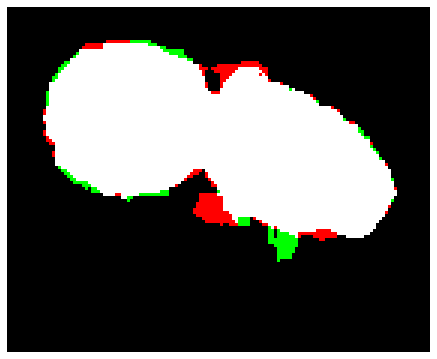

dataset1_ws_semiauto_org 76/151 (115, 141, 3)


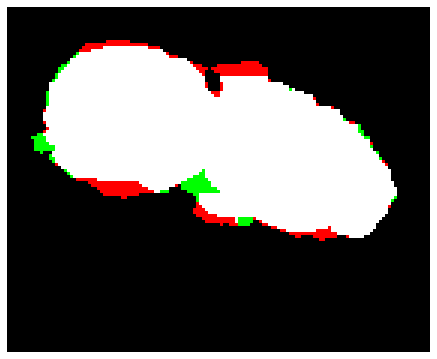

dataset1_ws_semiauto_smoothed 76/151 (115, 141, 3)


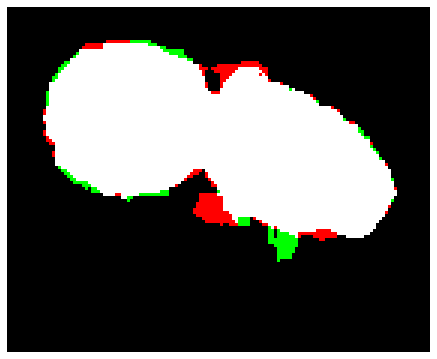

dataset2_ws_fullyauto_org 58/115 (87, 148, 3)


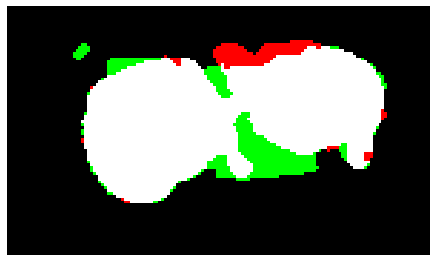

dataset2_ws_fullyauto_smoothed 58/115 (87, 148, 3)


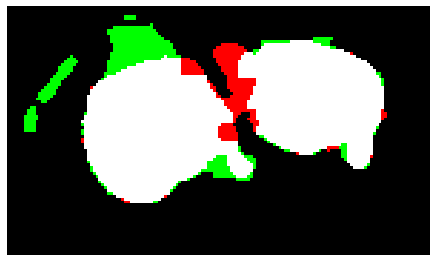

dataset2_ws_semiauto_org 58/115 (87, 148, 3)


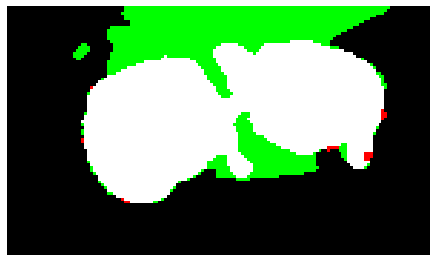

dataset2_ws_semiauto_smoothed 58/115 (87, 148, 3)


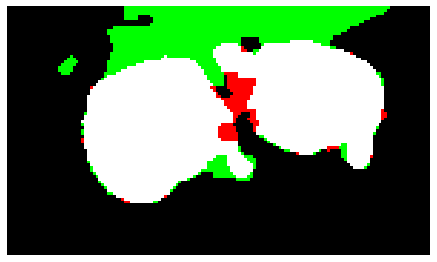

dataset3_ws_fullyauto_org 52/104 (148, 155, 3)


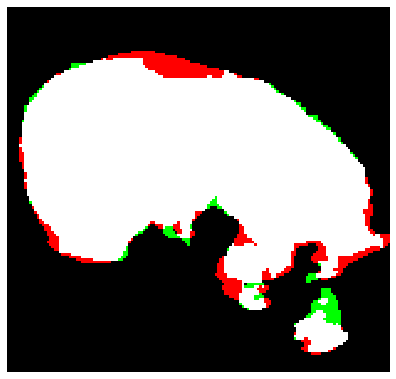

dataset3_ws_fullyauto_smoothed 52/104 (148, 155, 3)


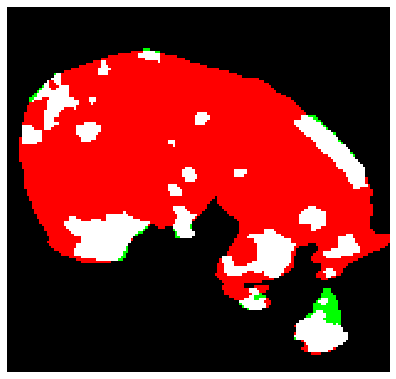

dataset3_ws_semiauto_org 52/104 (148, 155, 3)


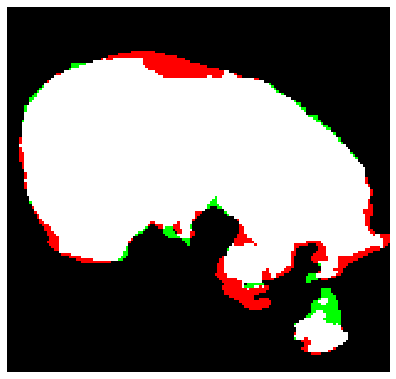

dataset3_ws_semiauto_smoothed 52/104 (148, 155, 3)


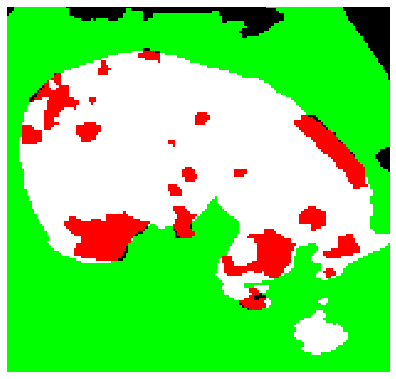

dataset4_ws_fullyauto_org 72/143 (111, 131, 3)


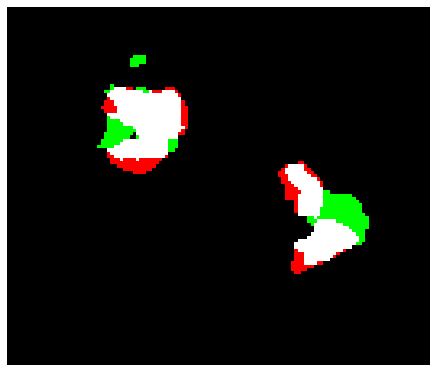

dataset4_ws_fullyauto_smoothed 72/143 (111, 131, 3)


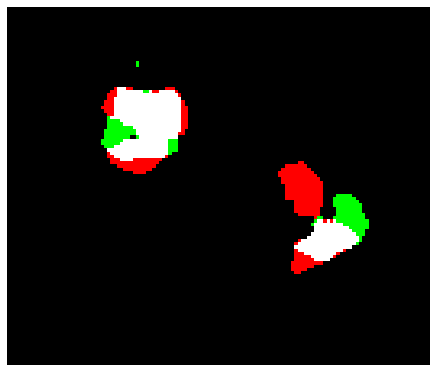

dataset4_ws_semiauto_org 72/143 (111, 131, 3)


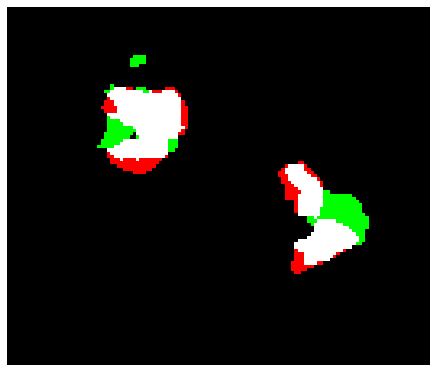

dataset4_ws_semiauto_smoothed 72/143 (111, 131, 3)


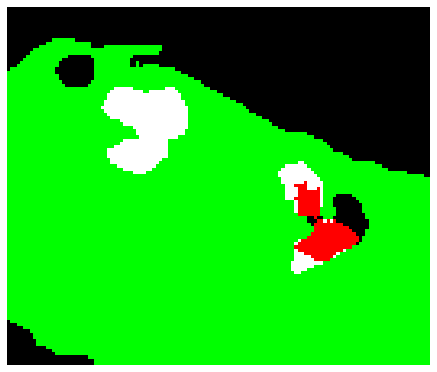

dataset5_ws_fullyauto_org 104/207 (144, 180, 3)


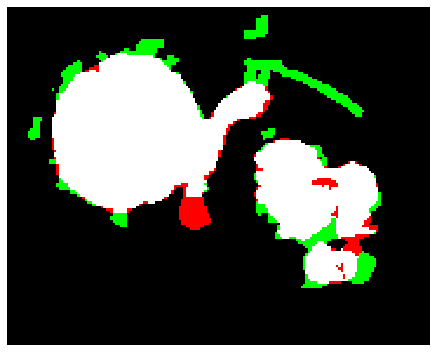

dataset5_ws_fullyauto_smoothed 104/207 (144, 180, 3)


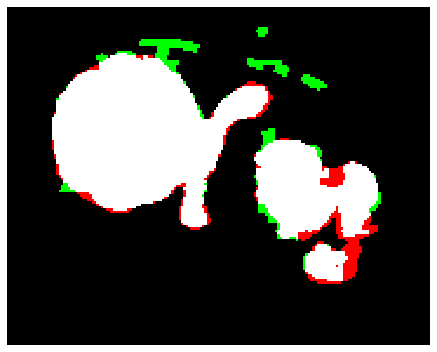

dataset5_ws_semiauto_org 104/207 (144, 180, 3)


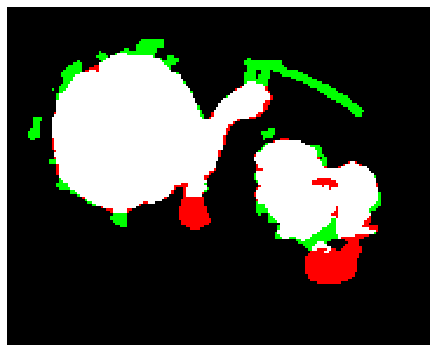

dataset5_ws_semiauto_smoothed 104/207 (144, 180, 3)


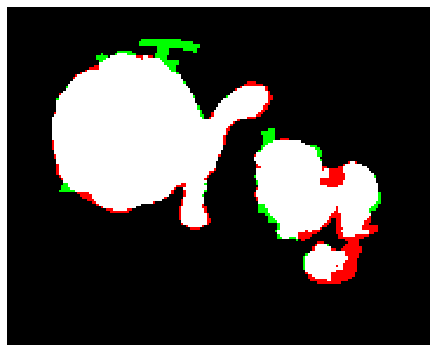

dataset6_ws_fullyauto_org 90/180 (112, 140, 3)


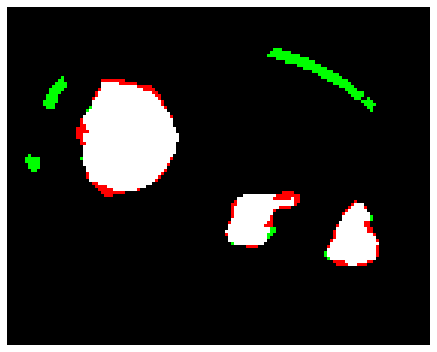

dataset6_ws_fullyauto_smoothed 90/180 (112, 140, 3)


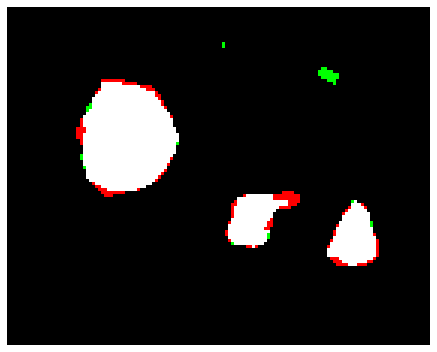

dataset6_ws_semiauto_org 90/180 (112, 140, 3)


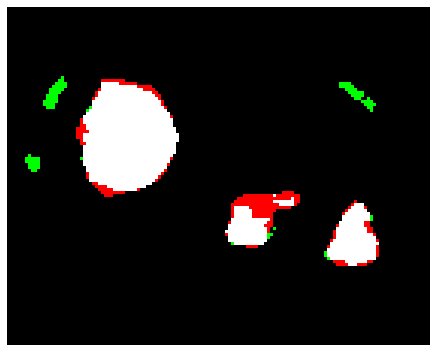

dataset6_ws_semiauto_smoothed 90/180 (112, 140, 3)


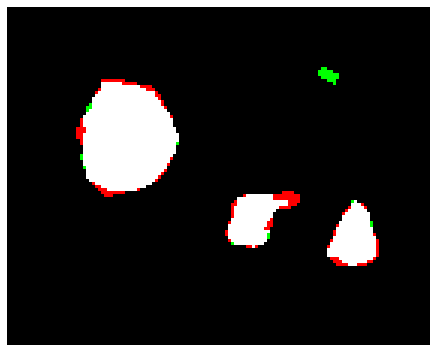

dataset7_ws_fullyauto_org 92/184 (161, 181, 3)


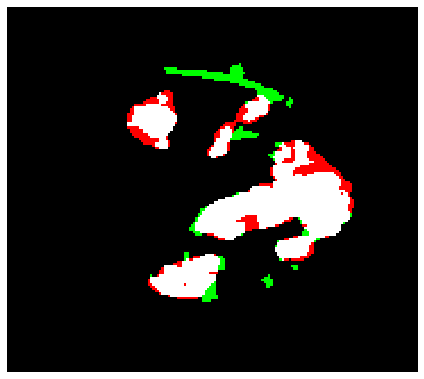

dataset7_ws_fullyauto_smoothed 92/184 (161, 181, 3)


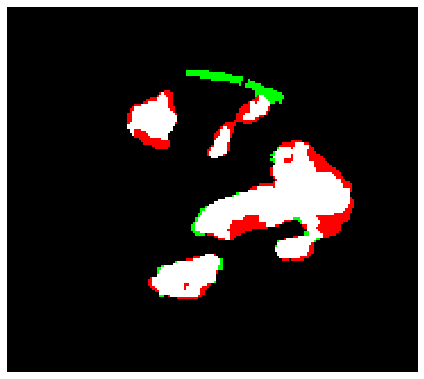

dataset7_ws_semiauto_org 92/184 (161, 181, 3)


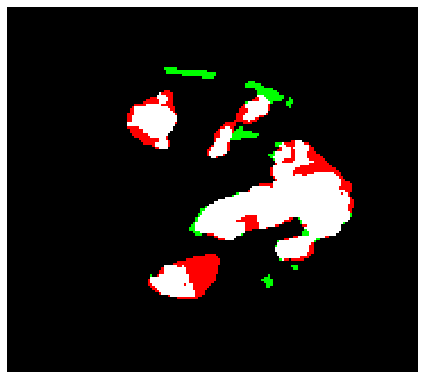

dataset7_ws_semiauto_smoothed 92/184 (161, 181, 3)


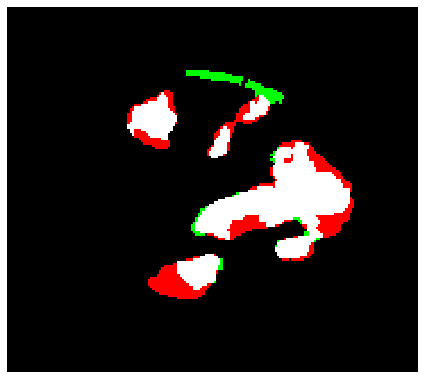

In [29]:
# save all the middle slices of the images
def save_images(data, name):
    for key, image in data.items():
        index = round(image.shape[0] /2.)
        titlename = key + ' ' + str(index) + '/' + str(image.shape[0]) + ' ' + str(image[index].shape)
        print(titlename)
        
        plt.imshow(image[index], cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plotname = name + '_' + str(key) + '_slice' + str(index) + '_'+ str(image.shape[0]) + '_size' + str(image[index].shape[1]) + '_' + str(image[index].shape[0])
        plt.savefig(RESULTS_PLOTS_PATH + '/' + plotname + '.png')
        plt.show()
        
# original images 
save_images(org_images, name = 'org')

# ground truth images 
save_images(gt_images, name = 'gt')

# heuristic model images 
save_images(colored_heuristicimages, name = 'heuristic')